<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/Reinforcement/Reasoning%20%7BRL%7D%20-%204%3A%20Deep-Q%20Convolution%20nw%20(Value%20based%20nw)%20-%20using%20Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Refrences
https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df

https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%204%20-%20Deep%20Q-Networks%20and%20Beyond%20with%20Keras.ipynb  -- Keras

https://github.com/awjuliani/DeepRL-Agents/blob/master/Double-Dueling-DQN.ipynb -- Tensorflow


Instead of a single layer perceptron or policy based n/w, we will be implmenting DeepQ N/w which are value based learners meaning in bellmon equation we will be learning the value of a given state + advantage of moving from a givent state when some action is performed which is different from policy based n/w where we just update n/w weight and dont care about value of states. 

**Value function V(s)** - which says simple how good network thinks it is in current state. 

**Advantage function A(a)** - which tells how much better taking a certain action would be compared to the others.

Q(s,a) = V(s) + A(a)   # This Equation will be used heavenly below.


### Changes



*   **Deep Q - convolution layers**  - here we will consider our input as an image where the whole image is a state and our n/w  will use convolution to know the meaning of states. 
*   **Experiance Relay** - We will be storing the states into a buffer and later we will sample the buffer to train our n/w on past experiances rather then immediate ones. The size of buffer is limited and is Queue based meaning only recent experiances are retained.
*   **Separate Target n/w** - We will have 2 n/w, 1st will generate Q-output values and 2nd will generate target Q values for loss calculations. The frequency of update for 2nd n/w is low compared to 1st, to help stablization. As if 2nd n/w value change whch are used to traing estimate Q values for each iteration system will never get stable 1 needed to be fixed (for certain duration).


In [0]:
!pip install tensorflow==2.0.0 > /dev/null 2>&1
!pip install tensorflow-gpu==2.0.0 > /dev/null 2>&1

### Env

Grid World Env, no need to study code.

In the environment the agent controls a blue square, and the goal is to navigate to the green squares (reward +1) while avoiding the red squares (reward -1).


In [0]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image

class gameOb():
    def __init__(self,coordinates,size,intensity,channel,reward,name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name
        
class gameEnv():
    def __init__(self,partial,size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        self.partial = partial
        
        a = self.reset()
        plt.imshow(a,interpolation="nearest")
        
        
    def reset(self):
        self.objects = []
        hero = gameOb(self.newPosition(),1,1,2,None,'hero')
        self.objects.append(hero)
        bug = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(bug)
        hole = gameOb(self.newPosition(),1,1,0,-1,'fire')
        self.objects.append(hole)
        bug2 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(bug2)
        hole2 = gameOb(self.newPosition(),1,1,0,-1,'fire')
        self.objects.append(hole2)
        bug3 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(bug3)
        bug4 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(bug4)
        state = self.renderEnv()
        self.state = state
        return state

    def moveChar(self,direction):
        # 0 - up, 1 - down, 2 - left, 3 - right
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        penalize = 0.
        if direction == 0 and hero.y >= 1:
            hero.y -= 1
        if direction == 1 and hero.y <= self.sizeY-2:
            hero.y += 1
        if direction == 2 and hero.x >= 1:
            hero.x -= 1
        if direction == 3 and hero.x <= self.sizeX-2:
            hero.x += 1     
        if hero.x == heroX and hero.y == heroY:
            penalize = 0.0
        self.objects[0] = hero
        return penalize
    
    def newPosition(self):
        iterables = [ range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        currentPositions = []
        for objectA in self.objects:
            if (objectA.x,objectA.y) not in currentPositions:
                currentPositions.append((objectA.x,objectA.y))
        for pos in currentPositions:
            points.remove(pos)
        location = np.random.choice(range(len(points)),replace=False)
        return points[location]

    def checkGoal(self):
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else:
                others.append(obj)
        ended = False
        for other in others:
            if hero.x == other.x and hero.y == other.y:
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(),1,1,1,1,'goal'))
                else: 
                    self.objects.append(gameOb(self.newPosition(),1,1,0,-1,'fire'))
                return other.reward,False
        if ended == False:
            return 0.0,False

    def renderEnv(self):
        #a = np.zeros([self.sizeY,self.sizeX,3])
        a = np.ones([self.sizeY+2,self.sizeX+2,3])
        a[1:-1,1:-1,:] = 0
        hero = None
        for item in self.objects:
            a[item.y+1:item.y+item.size+1,item.x+1:item.x+item.size+1,item.channel] = item.intensity
            if item.name == 'hero':
                hero = item
        if self.partial == True:
            a = a[hero.y:hero.y+3,hero.x:hero.x+3,:]

        # converting a low dimentinal array to an image with high dimention

        ''' Deprecated in scipy '''
#         b = scipy.misc.imresize(a[:,:,0], [84,84,1], interp='nearest')
#         c = scipy.misc.imresize(a[:,:,1], [84,84,1], interp='nearest')
#         d = scipy.misc.imresize(a[:,:,2], [84,84,1], interp='nearest')

        # (7, 7, 3) => (84, 84, 3)
        b = np.array(Image.fromarray(a[:,:,0]).resize((84, 84), Image.NEAREST)).reshape(84, 84)
        c = np.array(Image.fromarray(a[:,:,1]).resize((84, 84), Image.NEAREST)).reshape(84, 84)
        d = np.array(Image.fromarray(a[:,:,2]).resize((84, 84), Image.NEAREST)).reshape(84, 84)
        
        a = np.stack([b,c,d], axis=2)

        return a

    def step(self,action):
        penalty = self.moveChar(action)
        reward,done = self.checkGoal()
        state = self.renderEnv()
        if reward == None:
            print(done)
            print(reward)
            print(penalty)
            return state,(reward+penalty),done
        else:
            return state,(reward+penalty),done


## Codebase

In [0]:
from __future__ import division
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import scipy.misc
import os
%matplotlib inline

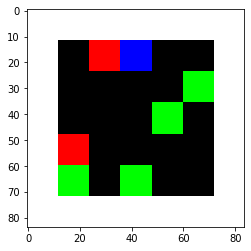

In [3]:
env = gameEnv(partial=False, size=5)

This is the game we'll be working on. The player can move the blue square up, down, left or right. The point of the game is to get to the green square (+1 reward) and avoid the red square (-1 reward). Blocks are randomized


Original shape: (84, 84, 3)


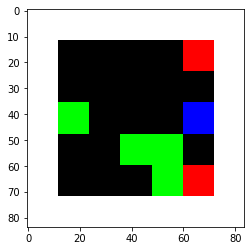

In [0]:
plt.imshow(env.state)
print("Original shape: {}".format(env.state.shape))

### Implemting Deep-Q Convolution n/w

In [8]:
from keras.models import Model
from keras.layers import Conv2D, Dense, Flatten, Input, Lambda
import keras.backend as K


def create_model(final_layer_size, im_size=84, lr=0.0001):
      inputs = Input(shape=[im_size, im_size, 3], name="main_input")

      # There will be four layers of convolutions performed on the image input
      # A convolution take a portion of an input and matrix multiplies
      # a filter on the portion to get a new input (see below)
      model = Conv2D(filters=32, kernel_size=[8,8], strides=[4,4], activation="relu", padding="valid", name="conv1")(inputs)
      model = Conv2D(filters=64, kernel_size=[4,4], strides=[2,2], activation="relu", padding="valid", name="conv2")(model)
      model = Conv2D(filters=64, kernel_size=[3,3], strides=[1,1], activation="relu", padding="valid", name="conv3")(model)
      model = Conv2D(filters= final_layer_size, kernel_size=[7,7], strides=[1,1], activation="relu",padding="valid", name="conv4")(model)
      
      
      # We then separate the final convolution layer into an advantage and value
      # stream, 1/2 weights attached to each.. The value function is how well off you are in a given state.
      # The advantage is the how much better off you are after making a particular
      # move. Q is the value function of a state after a given action.
      # Advantage(state, action) = Q(state, action) - Value(state)

      stream_AC = Lambda(lambda layer: layer[:,:,:,:final_layer_size // 2],name="advantage")(model)
      stream_VC = Lambda(lambda layer: layer[:,:,:,final_layer_size // 2:],name="value")(model)
      
      # We then flatten the advantage and value functions
      stream_AC = Flatten(name="advantage_flatten")(stream_AC)
      stream_VC = Flatten(name="value_flatten")(stream_VC)
      
      # We define weights for our advantage and value layers. We will train these
      # layers so the matmul will match the expected value and advantage from play
      Advantage = Dense(env.actions, name="advantage_final")(stream_AC)
      Value = Dense(1, name="value_final")(stream_VC)

      #Ques - what are we trying to optimize ?? Guess in Keras we dont define target varible and it is passed at training time. (train_on_batch)
      
      # To get the Q output, we need to add the value to the advantage.
      # The advantage to be evaluated will be based on how good the action
      # is based on the average advantage of that state
      model = Lambda(lambda x: x[0] + (x[1] - K.mean(x[1], axis=1, keepdims=True)), name="final_out")([Value, Advantage])
      
      model = Model(inputs, model)
      model.compile("adam", "mse")
      model.optimizer.lr = lr
      return model

model = create_model(512)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 84, 84, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 32)   6176        main_input[0][0]                 
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 9, 9, 64)     32832       conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 7, 7, 64)     36928       conv2[0][0]                      
____________________________________________________________________________________________

### Experience Replay
This class allows us to store experiences and sample them randomly for learning

In [0]:
class ExperienceReplay:
    def __init__(self, buffer_size=5000):
        """ Data structure used to hold game experiences """
        # Buffer will contain [state,action,reward,next_state,done]
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        """ Adds list of experiences to the buffer """
        # Extend the stored experiences
        self.buffer.extend(experience)
        # Keep the last buffer_size number of experiences
        self.buffer = self.buffer[-self.buffer_size:]
        
    def sample(self, size):
        """ Returns a sample of experiences from the buffer """
        sample_idxs = np.random.randint(len(self.buffer), size=size)
        sample_output = [self.buffer[idx] for idx in sample_idxs]
        sample_output = np.reshape(sample_output, (size, -1))
        return sample_output


### Training the network


Total Actions: 4
Num episode: 0 Mean reward: 4.0000 Prob random: 0.6000, Loss: 0.0000
Num episode: 25 Mean reward: 2.1200 Prob random: 0.6000, Loss: 0.0000
Num episode: 50 Mean reward: 2.1200 Prob random: 0.6000, Loss: 0.0000
Num episode: 75 Mean reward: 3.4800 Prob random: 0.6000, Loss: 0.0000
Num episode: 100 Mean reward: 3.2000 Prob random: 0.5995, Loss: 0.0260
Num episode: 125 Mean reward: 1.8800 Prob random: 0.5870, Loss: 0.0278
Num episode: 150 Mean reward: 1.4800 Prob random: 0.5745, Loss: 0.0263
Num episode: 175 Mean reward: 2.9600 Prob random: 0.5620, Loss: 0.0250
Num episode: 200 Mean reward: 4.0400 Prob random: 0.5495, Loss: 0.0246
Num episode: 225 Mean reward: 3.1600 Prob random: 0.5370, Loss: 0.0254
Num episode: 250 Mean reward: 6.3600 Prob random: 0.5245, Loss: 0.0273
Num episode: 275 Mean reward: 8.3200 Prob random: 0.5120, Loss: 0.0332
Num episode: 300 Mean reward: 11.3200 Prob random: 0.4995, Loss: 0.0492
Num episode: 325 Mean reward: 12.7600 Prob random: 0.4870, Loss:

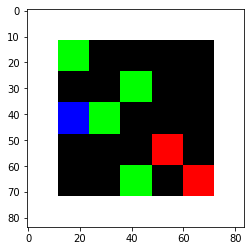

In [19]:
import os
import gym
import numpy as np
import tensorflow as tf

K.clear_session()

class DeepQModel():
  
  def __init__(self, lr=0.0001):
    # Reset everything

    self.final_layer_size = 512 #Size of the final convolution layer before splitting into Advantage and Value streams

    self.env = gameEnv(partial=False, size=5)
    self.env.reset()
    print("Total Actions:", self.env.actions)
    self.checkpoint_path = "training/cp.ckpt"

    # Setup our Q-networks
    self.main_qn = create_model(self.final_layer_size, lr=lr)
    self.target_qn = create_model(self.final_layer_size, lr=lr)

    # Setup our experience replay
    self.experience_replay = ExperienceReplay()
    self.lr = lr

    self.prob_random_start = 0.6 # Starting chance of random action
    self.prob_random_end = 0.1 # Ending chance of random action
    
    self.y = 0.99 # Discount factor
    self.tau = 1 # Rate to update target network toward primary network

    
    self.num_steps = [] # Tracks number of steps per episode
    self.rewards = [] # Tracks rewards per episode
    self.total_steps = 0  # Tracks cumulative steps taken in training

    # Make the networks equal
    self.update_target_graph()
    
    
#   def update_target_graph(self):
#       os.system("rm -rf %s" % self.checkpoint_path)
#       self.main_qn.save_weights(self.checkpoint_path)
#       self.target_qn.load_weights(self.checkpoint_path)
      
  def update_target_graph(self):
      updated_weights = (np.array(self.main_qn.get_weights()) * self.tau) + (np.array(self.target_qn.get_weights()) * (1 - self.tau))
      self.target_qn.set_weights(updated_weights)

  def build_experiance_buffer(self, num_episode, num_episodes, pre_train_episodes, steps, prob_random):
    
      # Create an experience replay for the current episode
      episode_buffer = ExperienceReplay()
      
      # Get the game state from the environment
      # self.env = gameEnv(partial=False, size=5)
      state = self.env.reset()
      done = False # Game is complete
      sum_rewards = 0 # Running sum of rewards in episode

      ''' Save all the interaction with Env '''
      for cntr in range(steps):
        state = state.astype(np.float32)
        if cntr >= steps or done:
          break

        self.total_steps += 1 
        
        if num_episode < pre_train_episodes or np.random.rand() < prob_random:        
#         if num_episode / float(num_episodes) < 0.10  or np.random.rand() < prob_random:
            # Act randomly based on prob_random or if we have not accumulated enough pre_train episodes
            action = np.random.randint(self.env.actions)
        else:
            # Decide what action to take from the Q network
            qouts = np.array(self.main_qn.predict(np.array([state])))
            action = np.array(np.argmax(qouts[0])).astype(np.int64)

        # Take the action and retrieve the next state, reward and done
        state_next, reward, done = self.env.step(action)

#         if int(reward) == 0:
#           reward = -0.1

        # Setup the episode to be stored in the episode buffer
        episode = np.array([[state], action, reward, [state_next], done])
        episode = episode.reshape(1,-1)

        # Store the experience in the episode buffer
        episode_buffer.add(episode)

        # Update the running rewards
        sum_rewards += reward

        # Update the state
        state = state_next

      self.experience_replay.add(episode_buffer.buffer)
      self.num_steps.append(cntr)
      self.rewards.append(sum_rewards)

  def print_status(self, num_episode, print_every, num_epochs, prob_random, goal):
    if not num_episode % print_every == 0:
      return False

    mean_loss = np.mean(self.losses[-(print_every * num_epochs):])
    print("Num episode: {} Mean reward: {:0.4f} Prob random: {:0.4f}, Loss: {:0.04f}".format(
        num_episode, np.mean(self.rewards[-print_every:]), prob_random, mean_loss))

    if np.mean(self.rewards[-print_every:]) >= goal:
        print("Training complete!")
        return True
    return False

  def execute_episodes(self, num_episodes=100, pre_train_episodes=100, batch_size=64, steps=1000, num_epochs=20, goal=5, evaluate_every=5, print_every=5):

    # We'll begin by acting complete randomly. As we gain experience and improve,
    # we will begin reducing the probability of acting randomly, and instead
    # take the actions that our Q network suggests

    annealing_steps = num_episodes
    prob_random = self.prob_random_start
    prob_random_drop = (self.prob_random_start - self.prob_random_end) / annealing_steps

    self.losses = [0]     # Tracking training losses

    for num_episode in range(num_episodes):
        self.build_experiance_buffer(num_episode, num_episodes, pre_train_episodes, steps, prob_random)
       
        if num_episode < pre_train_episodes:
          self.print_status(num_episode, print_every, num_epochs, prob_random, goal)
          continue
          
        if prob_random > self.prob_random_end:
            # Drop the probability of a random action
            prob_random -= prob_random_drop

        if not num_episode or not num_episode % evaluate_every == 0:
            continue

        for num_epoch in range(num_epochs):

            ''' Below Bellman equation will run we will use actual experiances from main model and
            will use actual reward + discounted rewards from target model to recalculate value

            target_q [action] = actual_reward (main_nw) + discounted_Qvalue (target_nw) 

            '''
            # Train batch is [[state,action,reward,next_state,done],...]
            train_batch = self.experience_replay.sample(batch_size)

            # Separate the batch into its components
            state_m, action_m, reward, state_next_m, done = train_batch.T

            # Convert the action array into an array of ints so they can be used for indexing
            action_m = action_m.astype(np.int)
            # Stack the states and train_next_state for learning
            state_m = np.vstack(state_m).astype(np.float32)
            state_next_m = np.vstack(state_next_m).astype(np.float32)

            ''' 
            In order to train n/w we need output from our target n/w modified with optimum rewards
            Based on Bellmon Equation we know that

            Q_out = rewards + discount_factor  * (future_rewards / advantage)

            We have rewards and duscount_factor, but advantage are unknown, advantage are just new state values from our target n/w.
            '''
            output_t = np.array(self.target_qn.predict(state_m))

            # The Q values from our main network from the next state
            output_state_next_m = np.array(self.main_qn.predict(state_next_m))

            action_state_next_m = np.argmax(output_state_next_m, axis=1).astype(np.int)
            # Q value of the next state based on action
            Qout_state_next_m = output_state_next_m[range(batch_size), action_state_next_m]

            ''''Tells us whether game over or not, We will multiply our rewards by this value to ensure we don't train on the last move '''
            done = done.astype(int)
            train_gameover = done == 0
            train_gameover = train_gameover.astype(int)
            # Reward from the action chosen in the train batch
            actual_reward = reward + (self.y * Qout_state_next_m * train_gameover)

            ''' Remember we are not overriding every value in output_t only the best action q value'''
            output_t[range(batch_size), action_m] = actual_reward

            # Train the main model
            '''
            Ideally we dont need target model, but here we can see that with each update weight will change
            which will contradict with target_q value we will be generating, hence we are keeping target constant but generating from 
            identical but slightly outdated same model copy.
            '''
#             loss = self.main_qn.train(state_m, output_t)
#             loss = self.train(state_m, output_t)
            loss = self.main_qn.train_on_batch(state_m, output_t)
            self.losses.append(loss)

        # Update the target model with values from the main model
        self.update_target_graph()

        # Print progress
        if self.print_status(num_episode, print_every, num_epochs, prob_random, goal):
          break

'''
batch_size - How many Experiences to use for each training step
steps = 1000 # Maximum allowed episode length
num_epochs = 20 # How many epochs to train from single episode experiances

save_every = 5   # How often to save
print_every = 5 # How often to print status
'''
obj = DeepQModel()
# obj.execute_episodes(num_episodes=31, pre_train_episodes=11, batch_size=64, steps=75, num_epochs=20, goal=25, evaluate_every=5, print_every=5)
obj.execute_episodes(num_episodes=1000, pre_train_episodes=100, batch_size=64, steps=75, num_epochs=20, goal=25, evaluate_every=5, print_every=25)

# obj.run_final_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


array([[ 0, 23],
       [ 1, 21],
       [ 2, 14],
       [ 3, 17]])

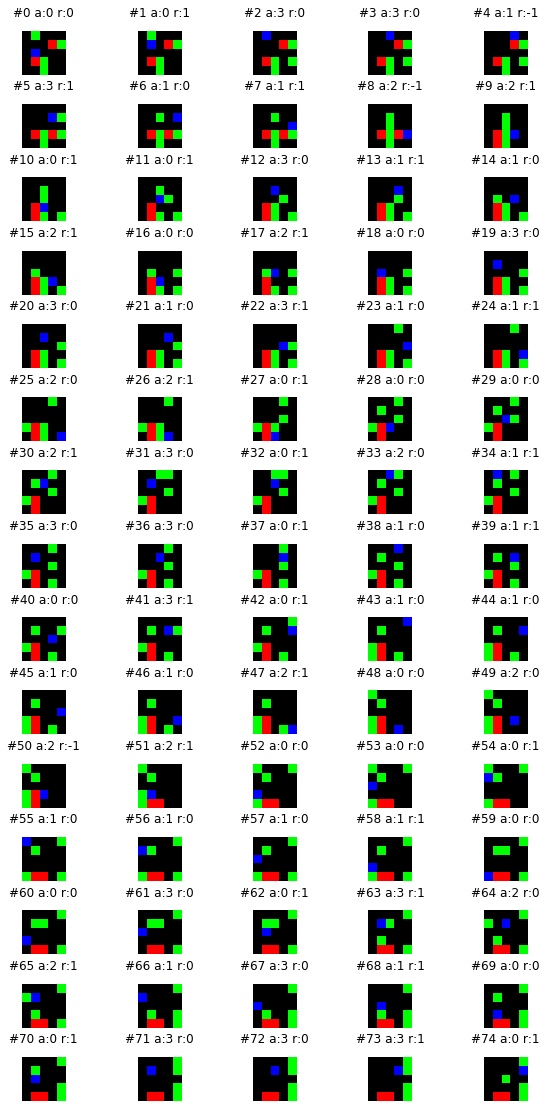

In [20]:
max_num_step = 75
f, axes = plt.subplots(nrows=max_num_step//5, ncols=5, sharex=True, sharey=True, figsize=(10,20))
done = False
num_step = 0
sum_rewards = 0

env = gameEnv(partial=False, size=5)
state = env.reset()

actions = []
while not done and num_step < max_num_step:
    qouts = np.array(obj.main_qn.predict(np.array([state])))
    action = np.argmax(qouts[0]).astype(np.int64)
#     action = np.random.randint(env.actions)
    actions.append(action)

    next_state, reward, done = env.step(np.array(action))
    ax = axes.ravel()[num_step]
    ax.imshow(state)
    ax.set_axis_off()
    ax.set_title("#{} a:{} r:{}".format(num_step, action, int(reward)))
    num_step += 1
    state = next_state

from scipy.stats import itemfreq
itemfreq(actions)